Notebook header & imports

In [1]:
# 02_dataset_and_augmentations.ipynb
# Goal:
# - Load label_mapping.json and dataset_index.json
# - Compute basic class/domain statistics
# - Define image transforms (PV basic, field-style, field, eval)
# - Implement a PyTorch Dataset that uses domain-aware transforms
# - Build balanced DataLoaders for training EfficientNet & ViT

from pathlib import Path
import json
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import torchvision.transforms as T

# Paths (must match 01_data_labeling.ipynb)
METADATA_DIR = Path("./metadata")
LABEL_MAPPING_PATH = METADATA_DIR / "label_mapping.json"
DATASET_INDEX_PATH = METADATA_DIR / "dataset_index.json"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


Load JSONs and build helper dicts

Number of classes: 39
Number of samples in dataset_index: 55448
Samples per split: Counter({'train': 44343, 'test': 5563, 'val': 5542})


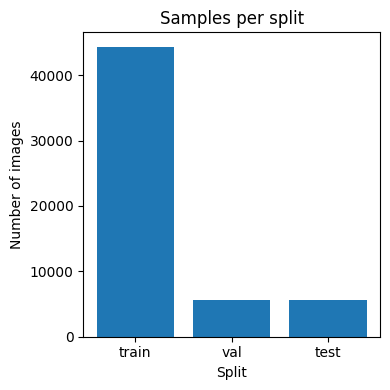

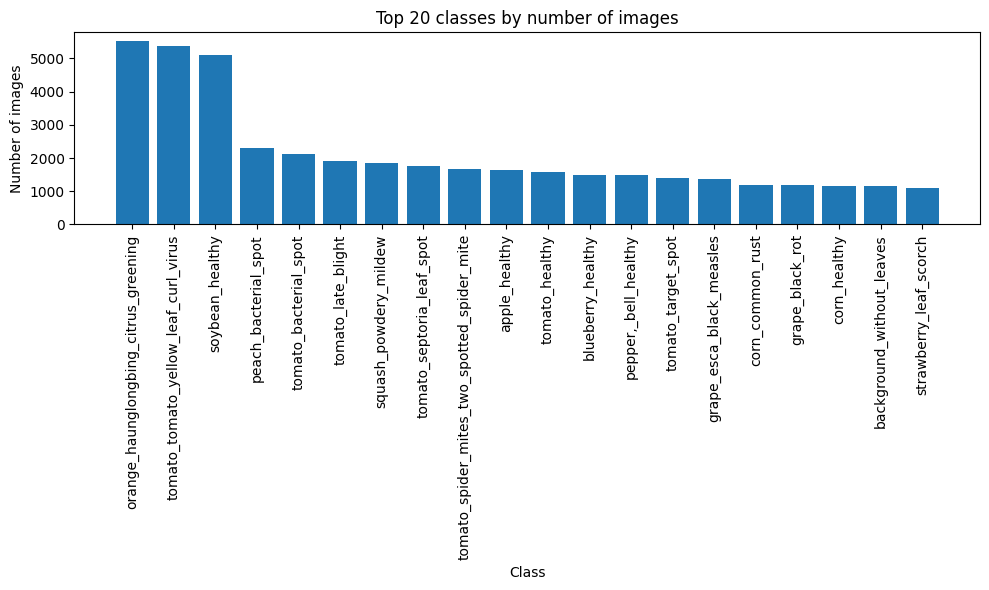

{'path': 'data\\Plant_leave_diseases_dataset_without_augmentation\\Apple___Apple_scab\\image (400).JPG', 'class_id': 0, 'domain': 'pv', 'split': 'train'}
{'path': 'data\\Plant_leave_diseases_dataset_without_augmentation\\Apple___Apple_scab\\image (104).JPG', 'class_id': 0, 'domain': 'pv', 'split': 'train'}
{'path': 'data\\Plant_leave_diseases_dataset_without_augmentation\\Apple___Apple_scab\\image (193).JPG', 'class_id': 0, 'domain': 'pv', 'split': 'train'}
{'path': 'data\\Plant_leave_diseases_dataset_without_augmentation\\Apple___Apple_scab\\image (201).JPG', 'class_id': 0, 'domain': 'pv', 'split': 'train'}
{'path': 'data\\Plant_leave_diseases_dataset_without_augmentation\\Apple___Apple_scab\\image (58).JPG', 'class_id': 0, 'domain': 'pv', 'split': 'train'}


In [2]:
# Cell 2 – Load JSONs and basic data visualization

from collections import Counter
import matplotlib.pyplot as plt

# --- Load label_mapping.json and dataset_index.json ---

with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)

with open(DATASET_INDEX_PATH, "r") as f:
    dataset_index = json.load(f)

num_classes = len(label_mapping["classes"])
print("Number of classes:", num_classes)
print("Number of samples in dataset_index:", len(dataset_index))

# Helper maps: id ↔ canonical_label
id_to_label = {c["id"]: c["canonical_label"] for c in label_mapping["classes"]}
label_to_id = {v: k for k, v in id_to_label.items()}

# --- Visualization 1: samples per split (train / val / test) ---

split_counts = Counter(e["split"] for e in dataset_index)
print("Samples per split:", split_counts)

plt.figure(figsize=(4, 4))
plt.bar(split_counts.keys(), split_counts.values())
plt.title("Samples per split")
plt.xlabel("Split")
plt.ylabel("Number of images")
plt.tight_layout()
plt.show()

# --- Visualization 2: class distribution (top 20 classes) ---

class_counts = Counter(e["class_id"] for e in dataset_index)

# Sort classes by count (descending)
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

top_n = 20  # show only top 20 to keep the plot readable
top_class_ids, top_counts = zip(*sorted_class_counts[:top_n])
top_labels = [id_to_label[cid] for cid in top_class_ids]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_counts)), top_counts)
plt.xticks(range(len(top_counts)), top_labels, rotation=90)
plt.title(f"Top {top_n} classes by number of images")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.tight_layout()
plt.show()

# --- Optional: print first few entries for sanity check ---

for sample in dataset_index[:5]:
    print(sample)


Compute basic statistics (per class & per domain)

In [3]:
class_counts = Counter()
domain_counts = Counter()
class_domain_counts = {}

for entry in dataset_index:
    cid = entry["class_id"]
    dom = entry.get("domain", "pv")

    class_counts[cid] += 1
    domain_counts[dom] += 1

    if cid not in class_domain_counts:
        class_domain_counts[cid] = Counter()
    class_domain_counts[cid][dom] += 1

print("Total samples per domain:", domain_counts)

print("\nFirst few classes with per-domain counts:")
for cid in range(min(5, num_classes)):
    cname = id_to_label[cid]
    counts = class_domain_counts.get(cid, {})
    print(f"Class {cid} ({cname}):", dict(counts))


Total samples per domain: Counter({'pv': 55448})

First few classes with per-domain counts:
Class 0 (apple_apple_scab): {'pv': 630}
Class 1 (apple_black_rot): {'pv': 621}
Class 2 (apple_cedar_apple_rust): {'pv': 275}
Class 3 (apple_healthy): {'pv': 1645}
Class 4 (background_without_leaves): {'pv': 1143}


Define transforms (PV, field-style, field, eval)

Using ImageNet mean/std and 224×224 as a default (works with EfficientNet & ViT from timm).

In [4]:
# Common normalization (ImageNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IMG_SIZE = 224  # can be tuned per model later

# Basic PV transform (light aug)
transform_pv_basic = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Strong "field-style" transform for PV images
transform_pv_field_style = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=20),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    T.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2)
    ),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    T.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
])


# Transform for *real* field images (slightly lighter)
transform_field = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Eval transform (no heavy augmentation)
transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


Identify “field-poor” classes

These are classes with few or no field samples (based on field_count from file 1).

In [5]:
FIELD_POOR_THRESHOLD = 5  # tweak as you like

field_count_by_class = {
    c["id"]: c.get("field_count", 0)
    for c in label_mapping["classes"]
}

field_poor_classes = {
    cid for cid, cnt in field_count_by_class.items()
    if cnt <= FIELD_POOR_THRESHOLD
}

print("Number of field-poor classes:", len(field_poor_classes))
print("Examples:", [id_to_label[cid] for cid in list(field_poor_classes)[:5]])


Number of field-poor classes: 39
Examples: ['apple_apple_scab', 'apple_black_rot', 'apple_cedar_apple_rust', 'apple_healthy', 'background_without_leaves']


Dataset class with domain-aware augmentations

In [6]:
class PlantDataset(Dataset):
    def __init__(self, entries, transform_train=True):
        """
        entries: list of dicts from dataset_index.json
        transform_train: True => train-time transforms; False => eval transforms
        """
        self.entries = entries
        self.transform_train = transform_train

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        img_path = item["path"]
        class_id = item["class_id"]
        domain = item.get("domain", "pv")  # 'pv', 'field', etc.

        img = Image.open(img_path).convert("RGB")

        if self.transform_train:
            # Training-time logic: choose transform based on domain + field-poor status
            if domain == "field":
                img = transform_field(img)
            elif domain == "pv":
                # For PV images of field-poor classes, sometimes apply strong field-style aug
                if class_id in field_poor_classes:
                    if torch.rand(1).item() < 0.5:
                        img = transform_pv_field_style(img)
                    else:
                        img = transform_pv_basic(img)
                else:
                    img = transform_pv_basic(img)
            else:
                # Any extra domain label you may add later (e.g., 'pv_field_style')
                img = transform_pv_field_style(img)
        else:
            # Evaluation-time transform
            img = transform_eval(img)

        target = class_id
        return img, target


Split entries into train/val/test and create Dataset objects

In [7]:
train_entries = [e for e in dataset_index if e["split"] == "train"]
val_entries   = [e for e in dataset_index if e["split"] == "val"]
test_entries  = [e for e in dataset_index if e["split"] == "test"]

print("Train:", len(train_entries), "Val:", len(val_entries), "Test:", len(test_entries))

train_dataset = PlantDataset(train_entries, transform_train=True)
val_dataset   = PlantDataset(val_entries,   transform_train=False)
test_dataset  = PlantDataset(test_entries,  transform_train=False)


Train: 44343 Val: 5542 Test: 5563


Build class weights and WeightedRandomSampler for training

In [8]:
# Compute class frequencies in the train set
train_class_counts = Counter([e["class_id"] for e in train_entries])

print("Number of classes in train:", len(train_class_counts))
print("First few class counts:", list(train_class_counts.items())[:5])

max_count = max(train_class_counts.values())
class_weights = {
    cid: max_count / count
    for cid, count in train_class_counts.items()
}

# One weight per sample
sample_weights = [class_weights[e["class_id"]] for e in train_entries]

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),  # you can also set > len for more steps per epoch
    replacement=True
)


Number of classes in train: 39
First few class counts: [(0, 504), (1, 496), (2, 220), (3, 1316), (4, 914)]


Create DataLoaders

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # or even 8 to test

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      # single-process
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)


In [10]:
# BATCH_SIZE = 32  # adjust to your GPU

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     sampler=sampler,      # balanced sampling
#     num_workers=4,
#     pin_memory=False
# )

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=4,
#     pin_memory=True
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True
# )

# print("Batches -> Train:", len(train_loader), "Val:", len(val_loader), "Test:", len(test_loader))


Quick sanity check batch

In [11]:
# batch = next(iter(train_loader))
# images, targets = batch
# print("Batch image tensor shape:", images.shape)
# print("Batch targets shape:", targets.shape)
# print("Unique labels in this batch:", targets.unique())


In [12]:
batch = next(iter(train_loader))
images, targets = batch
print("Batch image tensor shape:", images.shape)
print("Batch targets shape:", targets.shape)
print("Unique labels in this batch:", targets.unique())


Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch targets shape: torch.Size([32])
Unique labels in this batch: tensor([ 0,  3,  4,  6,  9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 31, 32,
        34, 36, 38])


In [13]:
import time
start = time.time()
batch = next(iter(train_loader))
print("time for one batch:", time.time() - start)
images, targets = batch
print("Batch image tensor shape:", images.shape)
print("Batch targets shape:", targets.shape)
print("Unique labels in this batch:", targets.unique())


time for one batch: 0.2601644992828369
Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch targets shape: torch.Size([32])
Unique labels in this batch: tensor([ 2,  3,  4,  5,  7, 10, 14, 16, 19, 20, 21, 25, 26, 28, 31, 34, 35, 36,
        38])
